In [2]:
import os, math, numpy as np, pandas as pd
from collections import defaultdict

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import SAGEConv, GCNConv
from sklearn.preprocessing import StandardScaler

In [ ]:
data = pd.read_parquet("custom_features_dataset.parquet")

In [4]:
data.columns

Index(['Timestamp', 'Src IP', 'Dst IP', 'Bwd Packet Length Min', 'Protocol_6',
       'Bwd Packets/s', 'FWD Init Win Bytes', 'Packet Length Std',
       'FIN Flag Count', 'SrcPortRange_registered', 'Packet Length Min',
       'Fwd Seg Size Min', 'DstPortRange_well_known', 'Bwd IAT Total',
       'SYN Flag Count', 'Bwd Packet Length Std', 'target'],
      dtype='object')

In [5]:
# Your edge feature columns (adjust if you want more/less)
EDGE_COLS = [
    'Bwd Packet Length Min', 'Protocol_6', 'Bwd Packets/s', 'FWD Init Win Bytes',
    'Packet Length Std', 'FIN Flag Count', 'SrcPortRange_registered',
    'Packet Length Min', 'Fwd Seg Size Min', 'DstPortRange_well_known',
    'Bwd IAT Total', 'SYN Flag Count', 'Bwd Packet Length Std'
]
ID_COLS = ['Src IP','Dst IP','Timestamp']
LABEL_COL = 'target'   # binary {0,1}

# Time encoding (periods in seconds)
def time_posenc(t, periods=(60, 300, 3600)):
    # t: numpy array of epoch seconds
    feats = []
    for P in periods:
        w = 2*math.pi/P
        feats.append(np.sin(w*t))
        feats.append(np.cos(w*t))
    return np.stack(feats, axis=1)  # [N, 2*len(periods)]

In [6]:
def bin_time(df, bin_seconds=300):
    # Expect df['Timestamp'] as datetime or string; convert to seconds
    ts = pd.to_datetime(df['Timestamp'], errors='coerce', utc=True).astype('int64') // 10**9
    df = df.copy()
    df['_epoch'] = ts
    df['_bin'] = (ts // bin_seconds).astype(int)
    return df

def build_snapshots(df, scaler_edge=None, fit_scaler=False, bin_seconds=300, device='cpu'):
    """
    Returns:
      snapshots: list[Data] in time order
      ip2idx: dict mapping IP -> node index (per full dataset, stable across train/test)
      scaler_edge: fitted StandardScaler for edge features
      edge_cols_kept: list of columns used (existing + non-NA)
    """
    # Keep only available columns
    edge_cols = [c for c in EDGE_COLS if c in df.columns]
    cols_needed = ID_COLS + edge_cols + [LABEL_COL]
    cols_needed = [c for c in cols_needed if c in df.columns]
    df = df[cols_needed].dropna(subset=['Src IP','Dst IP'])
    df = bin_time(df, bin_seconds=bin_seconds)

    # Edge feature scaler
    if scaler_edge is None:
        scaler_edge = StandardScaler()
        fit_scaler = True
    if fit_scaler:
        scaler_edge.fit(df[edge_cols].astype(float).values)

    # Stable node indexing across all snapshots in this split
    ips = pd.Index(pd.unique(pd.concat([df['Src IP'], df['Dst IP']])))
    ip2idx = {ip:i for i,ip in enumerate(ips)}

    snapshots = []
    # For 1-bin lag activity: track per-node edge count in previous bin
    prev_activity = defaultdict(int)

    for b, g in df.sort_values('_bin').groupby('_bin'):
        # Map nodes
        src = g['Src IP'].map(ip2idx).astype(int).values
        dst = g['Dst IP'].map(ip2idx).astype(int).values
        edge_index = torch.tensor(np.vstack([src, dst]), dtype=torch.long)

        # Edge attributes = scaled flow features + time encoding
        eX = scaler_edge.transform(g[edge_cols].astype(float).values)
        tfe = time_posenc(g['_epoch'].values)  # [E, 2*len(periods)]
        edge_attr = torch.tensor(np.hstack([eX, tfe]), dtype=torch.float)

        # Labels (edge-level)
        y = torch.tensor(g[LABEL_COL].astype(int).values, dtype=torch.long)

        # Node features (inductive, not learned):
        #   in/out/total degree in THIS snapshot + previous-bin activity count
        n_nodes = len(ip2idx)
        out_deg = np.bincount(src, minlength=n_nodes)
        in_deg  = np.bincount(dst, minlength=n_nodes)
        deg     = (out_deg + in_deg).reshape(-1,1)
        node_feat = np.hstack([
            in_deg.reshape(-1,1),
            out_deg.reshape(-1,1),
            deg,
            np.array([prev_activity[i] for i in range(n_nodes)]).reshape(-1,1)
        ])
        # log1p to compress scale
        node_feat = np.log1p(node_feat)
        x = torch.tensor(node_feat, dtype=torch.float)

        data = Data(
            x=x,
            edge_index=edge_index,
            edge_attr=edge_attr,
            y=y
        )
        # Store mapping to recover edge order if needed
        data._bin = int(b)
        snapshots.append(data)

        # Update prev_activity for next bin (count edges touched by node this bin)
        touched = np.bincount(np.concatenate([src, dst]), minlength=n_nodes)
        for i, c in enumerate(touched):
            prev_activity[i] = int(c)

    # Move to device lazily in loader/training
    return snapshots, ip2idx, scaler_edge, edge_cols + [f'time_{i}' for i in range(tfe.shape[1])]

In [7]:
class GraphTimeEdgeClassifier(nn.Module):
    def __init__(self, in_node, in_edge, hidden=64, gnn='sage', num_layers=2, dropout=0.1):
        super().__init__()
        Convs = []
        if gnn == 'sage':
            Conv = SAGEConv
        elif gnn == 'gcn':
            Conv = GCNConv
        else:
            raise ValueError("gnn must be 'sage' or 'gcn'")

        dims = [in_node] + [hidden]*num_layers
        for i in range(num_layers):
            Convs.append(Conv(dims[i], dims[i+1]))
        self.convs = nn.ModuleList(Convs)
        self.dropout = nn.Dropout(dropout)

        # Edge MLP head
        self.edge_mlp = nn.Sequential(
            nn.Linear(2*hidden + in_edge, hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden, 2)
        )

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr

        for conv in self.convs:
            x = conv(x, edge_index)
            x = F.relu(x)
            x = self.dropout(x)

        src, dst = edge_index
        h_src = x[src]
        h_dst = x[dst]
        z = torch.cat([h_src, h_dst, edge_attr], dim=1)
        logits = self.edge_mlp(z)
        return logits


In [8]:
def run_epoch(model, snapshots, optimizer=None, device='cpu'):
    is_train = optimizer is not None
    total_loss, total_correct, total_edges = 0.0, 0, 0
    ce = nn.CrossEntropyLoss()

    for data in snapshots:
        data = data.to(device)
        logits = model(data)
        if is_train:
            loss = ce(logits, data.y)
            optimizer.zero_grad(set_to_none=True)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 2.0)
            optimizer.step()
            total_loss += float(loss.item()) * data.y.numel()
        with torch.no_grad():
            pred = logits.argmax(dim=1)
            total_correct += int((pred == data.y).sum())
            total_edges += int(data.y.numel())

    avg_loss = total_loss / max(1, total_edges) if is_train else None
    acc = total_correct / max(1, total_edges)
    return avg_loss, acc


In [9]:
split_ratio = 0.8
train_df = data[:int(len(data)*split_ratio)]
test_df = data[int(len(data)*split_ratio):]

In [10]:
# Assume you already have train_df and test_df with the listed columns
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Build train snapshots (fit scaler)
train_snaps, train_ip2idx, scaler_edge, edge_cols_used = build_snapshots(
    train_df, scaler_edge=None, fit_scaler=True, bin_seconds=300, device=device
)

# Build test snapshots (reuse scaler; allow different IP set)
# To preserve strict inductive setting, we build a separate ip2idx for test (no shared node IDs).
test_snaps, test_ip2idx, _, _ = build_snapshots(
    test_df, scaler_edge=scaler_edge, fit_scaler=False, bin_seconds=300, device=device
)

In [11]:
device

'cuda'

In [13]:
# Model dims
in_node = train_snaps[0].x.size(1)             # [in_deg, out_deg, deg, prev_activity] -> 4
in_edge = train_snaps[0].edge_attr.size(1)     # len(EDGE_COLS_kept) + time_posenc
model = GraphTimeEdgeClassifier(in_node=in_node, in_edge=in_edge,
                                hidden=32, gnn='gcn', num_layers=2, dropout=0.2).to(device)

opt = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

EPOCHS = 10
for epoch in range(1, EPOCHS+1):
    tr_loss, tr_acc = run_epoch(model, train_snaps, optimizer=opt, device=device)
    _, te_acc = run_epoch(model, test_snaps, optimizer=None, device=device)
    print(f"Epoch {epoch:02d} | train loss {tr_loss:.4f} | train acc {tr_acc:.4f} | test acc {te_acc:.4f}")


Epoch 01 | train loss 49.0185 | train acc 0.9014 | test acc 0.8326
Epoch 02 | train loss 12.0875 | train acc 0.9331 | test acc 0.8409
Epoch 03 | train loss 0.9196 | train acc 0.9706 | test acc 0.9401
Epoch 04 | train loss 0.0356 | train acc 0.9945 | test acc 0.9895
Epoch 05 | train loss 0.0121 | train acc 0.9974 | test acc 0.9952
Epoch 06 | train loss 0.0100 | train acc 0.9985 | test acc 0.9988
Epoch 07 | train loss 0.0125 | train acc 0.9932 | test acc 0.9855
Epoch 08 | train loss 0.0083 | train acc 0.9980 | test acc 0.9856
Epoch 09 | train loss 0.0069 | train acc 0.9978 | test acc 0.9991
Epoch 10 | train loss 0.0397 | train acc 0.9970 | test acc 0.9994


In [14]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_with_confusion(model, snapshots, device='cpu'):
    all_preds = []
    all_labels = []

    model.eval()
    with torch.no_grad():
        for data in snapshots:
            data = data.to(device)
            logits = model(data)
            preds = logits.argmax(dim=1).cpu().numpy()
            labels = data.y.cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels)

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    report = classification_report(all_labels, all_preds, digits=4)

    # Plot confusion matrix
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Pred 0', 'Pred 1'],
                yticklabels=['True 0', 'True 1'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix (Test Set)')
    plt.show()

    print("📊 Classification Report:")
    print(report)

    return cm, report

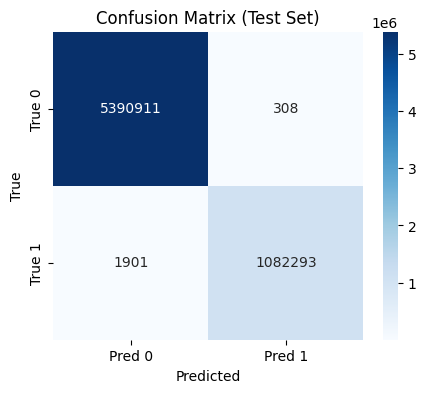

📊 Classification Report:
              precision    recall  f1-score   support

           0     0.9996    0.9999    0.9998   5391219
           1     0.9997    0.9982    0.9990   1084194

    accuracy                         0.9997   6475413
   macro avg     0.9997    0.9991    0.9994   6475413
weighted avg     0.9997    0.9997    0.9997   6475413



In [15]:
# gcn
cm, report = evaluate_with_confusion(model, test_snaps, device=device)

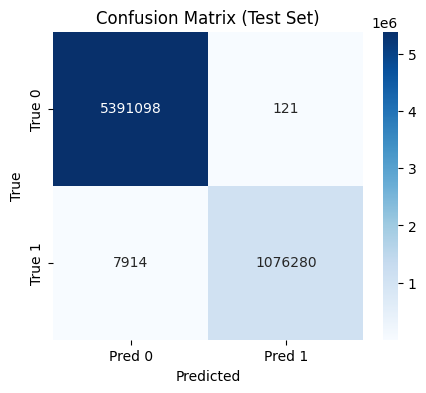

📊 Classification Report:
              precision    recall  f1-score   support

           0     0.9985    1.0000    0.9993   5391219
           1     0.9999    0.9927    0.9963   1084194

    accuracy                         0.9988   6475413
   macro avg     0.9992    0.9963    0.9978   6475413
weighted avg     0.9988    0.9988    0.9988   6475413



In [ ]:
# sage
cm, report = evaluate_with_confusion(model, test_snaps, device=device)